In [1]:
# This file uses the inhouse qcbm code from the paper and compares MMD with MCR
import numpy as np
import matplotlib.pyplot as plt
import copy
import q_circuit as q # In house circuit code, to comare with Qiskit
import torch
import time
import os

# Oh Hail the almighty Qiskit:
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit import IBMQ
from qiskit.providers.jobstatus import JobStatus

# Import custom packages: These are written by me
import InHouse_Circuits as ihc
import Qiskit_Circuits as qkc
import Q_Generator as QG
import Q_Loss_and_Gradients as Q_gradients
import Utils
import Discriminator_Utils as D_utils # A file that contains different discriminator architectures

In [3]:
# IBMQ.enable_account("a66a83268fbf696a24b481c5d7568d50f14a1b2f28c6932d600a625b9cbffc6e28a6594bdd422676c9b2a214dcafa87d57012cc8678cbabaeecb319a0515f4c2")

In [3]:
# provider = IBMQ.get_provider(hub='ibm-q')
# provider.backends()

In [4]:
#backend = provider.get_backend('simulator_statevector')

Create a simple example with in house circuit and gaussian RBF kernel, learning Gaussian distribution

In [2]:
#======================================Start of Configurations=================================
n_qubits = 4 # We use 4 qubits
n_layers = 6 # 2 layers of circuit gates
geometry = (2,2) # The qubits are put on a 2 by 2 graph
connections = q.get_nn_pairs(geometry) # The qubits are CNOT-entangled by nearest neighbors on the 2 by 2 graph

# Since the simulation is small enough, we keep track of the whole probability space
# The basis looks like [[0,0,0,0], [0,0,0,1], [0,0,1,0], [0,0,1,1],...[1,1,1,1]]
x_basis_m_n = torch.FloatTensor(Utils.binary_basis((np.prod(geometry),))) 
sigma_list = [0.5, 1]
shots = 100 # We sample 100 observations from the quantum system as observations
mcr_eps = 0.1
output_dim = 2
loss_func = "MMD" # The vanilla GAN loss, choose from ["GAN", "MCR", "MMD", "MCR_MMD"]
kernel = 'deep_rbf_kernel' # choose from ['deep_rbf_kernel', 'feature_kerel']
#======================================End of Configurations====================================
# Create a circuit using the configurations above
#circuit0 = ihc.MLP_Circuit(n_qubits, n_layers, connections, shots)

simulator = qiskit.Aer.get_backend('statevector_simulator')
circuit0 = qkc.MLP_Circuit(n_qubits, n_layers, connections, simulator, shots, if_measure=False)
# Create a deep NN discriminator choose from ["MCR_Discriminator", "Vanilla_Discriminator"]
if loss_func == "MMD":
    D = D_utils.MMD_Discriminator(input_dim=n_qubits, output_dim=output_dim)
elif loss_func == "MCR":
    D = D_utils.MCR_Discriminator(input_dim=n_qubits, output_dim=output_dim) # with batch norm in the last layer
elif loss_func == "GAN":
    D = D_utils.Vanilla_Discriminator(input_dim=n_qubits, output_dim=output_dim)
else:
    print('unspecified loss function')

# Create the quantum gradient module
q_grad = Q_gradients.Q_gradients_by_density(D, x_basis_m_n, mcr_eps, sigma_list,
                                           if_deep_rbf_kernel=True, if_feature_kernel=True)
# Create a quantum data generator using this circuit as the core, trained via MMD loss
G = QG.Q_Generator(circuit0, q_grad, loss_func_name=loss_func+'_'+kernel)

length of theta list 72


In [7]:
# testing out the MBL circuit
connections = q.get_nn_pairs((2,))
circuit1 = qkc.MBL_Circuit(delta_t=1, trotter_r=2, Jxy=1.0, Jzz=0, n_qubits=2, n_h_qubits=1, connections=connections, 
                           backend=simulator, shots=shots, if_measure=False)
theta_list = -torch.rand((circuit1.current_m+1)*circuit1.n_qubits)*np.pi
circuit1.pdf_sample(torch.tensor([0,0]))

{Parameter(theta-0-0): 0, Parameter(theta-0-1): 0}
Statevector([ 0.5       +0.j        , -0.32682181+0.37840125j,
             -0.32682181+0.37840125j,  0.5       +0.j        ],
            dims=(2, 2))
probabilities [0.5+0.j 0.5+0.j]


tensor([0.5000, 0.5000])

In [8]:
circuit1.append_layers_m(m=1)

In [14]:
circuit1.pdf_actual(torch.rand((circuit1.current_m+1)*circuit1.n_qubits)*2*np.pi) # now we have the theta_list shape as m*q

{Parameter(theta-0-0): 4.51356, Parameter(theta-0-1): 2.3476787, Parameter(theta-1-0): 5.0345287, Parameter(theta-1-1): 4.8859816}
Statevector([-0.23840008+0.43950586j,  0.41006419-0.34776355j,
              0.04922941-0.45660085j, -0.23840008-0.43950586j],
            dims=(2, 2))
probabilities [0.46090787+0.j 0.53909213+0.j]


tensor([0.4609, 0.5391])

In [11]:
circuit1.current_m

1

In [4]:
circuit1.pdf_actual(torch.tensor([0,0]))

{Parameter(theta-0-0): 0, Parameter(theta-0-1): 0}
Statevector([ 0.5       +0.j        , -0.32682181+0.37840125j,
             -0.32682181+0.37840125j,  0.5       +0.j        ],
            dims=(2, 2))
probabilities [0.5+0.j 0.5+0.j]


tensor([0.5000, 0.5000])

In [5]:
circuit1._circuit.draw()

┌───┐┌─────────┐┌─────────┐        ┌─────────┐┌─────────┐        »
q_0: ┤ H ├┤0        ├┤0        ├─■──────┤1        ├┤1        ├─■──────»
     ├───┤│  Rxx(1) ││  Ryy(1) │ │ZZ(0) │  Rxx(1) ││  Ryy(1) │ │ZZ(0) »
q_1: ┤ H ├┤1        ├┤1        ├─■──────┤0        ├┤0        ├─■──────»
     └───┘└─────────┘└─────────┘        └─────────┘└─────────┘        »
c: 1/═════════════════════════════════════════════════════════════════»
                                                                      »
«     ┌───────────────┐┌─────────┐┌─────────┐        ┌─────────┐┌─────────┐»
«q_0: ┤ Rz(theta-0-0) ├┤0        ├┤0        ├─■──────┤1        ├┤1        ├»
«     ├───────────────┤│  Rxx(1) ││  Ryy(1) │ │ZZ(0) │  Rxx(1) ││  Ryy(1) │»
«q_1: ┤ Rz(theta-0-1) ├┤1        ├┤1        ├─■──────┤0        ├┤0        ├»
«     └───────────────┘└─────────┘└─────────┘        └─────────┘└─────────┘»
«c: 1/═════════════════════════════════════════════════════════════════════»
«                                                                          »
«             ┌───────────────┐
«q_0: ─■──────┤ Rz(theta-0-0) ├
«      │ZZ(0) ├───────────────┤
«q_1: ─■──────┤ Rz(theta-0-1) ├
«             └───────────────┘
«c: 1/═════════════════════════
«

In [10]:
q.get_nn_pairs((2,))[:]

[(0, 1), (1, 0)]

In [5]:
circuit1._circuit.draw()

┌───────┐
q_0: ┤ Rz(3) ├
     ├───────┤
q_1: ┤ Rz(3) ├
     └───────┘
c: 1/═════════

In [6]:
torch.rand((circuit1.current_m+1)*circuit1.n_qubits)*2*np.pi

tensor([5.4698, 1.1626, 0.8147, 2.6724, 2.3156])

In [21]:
connections

(0, 1)

In [13]:
circuit0.pdf_actual(torch.rand((circuit0.n_layers*circuit0.n_qubits*3))*2*np.pi)

tensor([0.1358, 0.0133, 0.0263, 0.0301, 0.2576, 0.0415, 0.1475, 0.1212, 0.0216,
        0.0069, 0.0425, 0.0014, 0.0081, 0.0276, 0.0359, 0.0827])

In [13]:
torch.rand((circuit1.current_m+1)*circuit1.n_qubits)*2*np.pi

tensor([0.3210, 4.3065, 4.7059, 4.5572, 3.3600])

In [16]:
circuit1._circuit.parameters[0].data

AttributeError: 'Parameter' object has no attribute 'data'

In [7]:
circuit1._circuit.draw()

┌─────────┐         ┌─────────┐                         »
q_0: ────┤0        ├─────────┤0        ├────────────■────────────»
         │         │         │         │            │            »
q_1: ────┤  Rxx(0) ├─────────┤  Ryy(0) ├────────────┼────────────»
         │         │         │         │            │ZZ(0)       »
q_2: ────┤1        ├─────────┤1        ├────────────■────────────»
         └─────────┘         └─────────┘                         »
q_3: ────────────────────────────────────────────────────────────»
     ┌──────────────────┐┌──────────────────┐┌──────────────────┐»
q_4: ┤ Rz(theta-0-4/10) ├┤ Rz(theta-0-4/10) ├┤ Rz(theta-0-4/10) ├»
     └──────────────────┘└──────────────────┘└──────────────────┘»
c: 3/════════════════════════════════════════════════════════════»
                                                                 »
«         ┌─────────┐         ┌─────────┐                         »
«q_0: ────┤0        ├─────────┤0        ├────────────■────────────»
«         │  Rxx(0) │         │  Ryy(0) │            │ZZ(0)       »
«q_1: ────┤1        ├─────────┤1        ├────────────■────────────»
«         └─────────┘         └─────────┘                         »
«q_2: ────────────────────────────────────────────────────────────»
«                                                                 »
«q_3: ────────────────────────────────────────────────────────────»
«     ┌──────────────────┐┌──────────────────┐┌──────────────────┐»
«q_4: ┤ Rz(theta-0-4/10) ├┤ Rz(theta-0-4/10) ├┤ Rz(theta-0-4/10) ├»
«     └──────────────────┘└──────────────────┘└──────────────────┘»
«c: 3/════════════════════════════════════════════════════════════»
«                                                                 »
«                                                                 »
«q_0: ────────────────────────────────────────────────────────────»
«         ┌─────────┐         ┌─────────┐                         »
«q_1: ────┤0        ├─────────┤0        ├────────────■────────────»
«         │         │         │         │            │            »
«q_2: ────┤  Rxx(0) ├─────────┤  Ryy(0) ├────────────┼────────────»
«         │         │         │         │            │ZZ(0)       »
«q_3: ────┤1        ├─────────┤1        ├────────────■────────────»
«     ┌───┴─────────┴────┐┌───┴─────────┴────┐┌──────────────────┐»
«q_4: ┤ Rz(theta-0-4/10) ├┤ Rz(theta-0-4/10) ├┤ Rz(theta-0-4/10) ├»
«     └──────────────────┘└──────────────────┘└──────────────────┘»
«c: 3/════════════════════════════════════════════════════════════»
«                                                                 »
«         ┌─────────┐         ┌─────────┐                         »
«q_0: ────┤1        ├─────────┤1        ├────────────■────────────»
«         │  Rxx(0) │         │  Ryy(0) │            │ZZ(0)       »
«q_1: ────┤0        ├─────────┤0        ├────────────■────────────»
«         └─────────┘         └─────────┘                         »
«q_2: ────────────────────────────────────────────────────────────»
«                                                                 »
«q_3: ────────────────────────────────────────────────────────────»
«     ┌──────────────────┐┌──────────────────┐┌──────────────────┐»
«q_4: ┤ Rz(theta-0-4/10) ├┤ Rz(theta-0-4/10) ├┤ Rz(theta-0-4/10) ├»
«     └──────────────────┘└──────────────────┘└──────────────────┘»
«c: 3/════════════════════════════════════════════════════════════»
«                                                                 »
«         ┌─────────┐         ┌─────────┐                         »
«q_0: ────┤1        ├─────────┤1        ├────────────■────────────»
«         │         │         │         │            │            »
«q_1: ────┤  Rxx(0) ├─────────┤  Ryy(0) ├────────────┼────────────»
«         │         │         │         │            │ZZ(0)       »
«q_2: ────┤0        ├─────────┤0        ├────────────■────────────»
«         └─────────┘         └─────────┘                         »
«q_3: ────

In [5]:
circuit1.thetas
circuit1._circuit.clbits


[Clbit(ClassicalRegister(3, 'c'), 0),
 Clbit(ClassicalRegister(3, 'c'), 1),
 Clbit(ClassicalRegister(3, 'c'), 2)]

In [6]:
circuit1._circuit.qubits

[Qubit(QuantumRegister(5, 'q'), 0),
 Qubit(QuantumRegister(5, 'q'), 1),
 Qubit(QuantumRegister(5, 'q'), 2),
 Qubit(QuantumRegister(5, 'q'), 3),
 Qubit(QuantumRegister(5, 'q'), 4)]

In [5]:
theta_list = torch.zeros((circuit1.current_m+1)*circuit1.n_qubits)
circuit1.pdf_sample(theta_list)

{'000 000': 100}


ValueError: invalid literal for int() with base 2: '000 000'

Text(0.5, 1.0, 'target distribution')

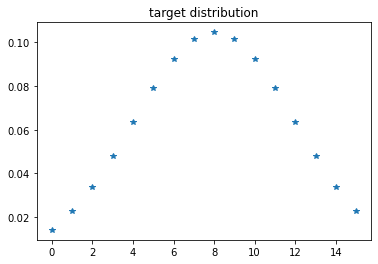

In [6]:
#======================================Create p_data==========================================
hdim = 2**n_qubits
p_data = torch.FloatTensor(Utils.gaussian_pdf((n_qubits,), hdim/2., hdim/4.))
plt.plot(p_data, '*')
plt.title('target distribution')

In [7]:
#==============================Setup Adam optimizer the quantum generator===========================
lr = 1e-4
beta1 = 0.9
optimizerG = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = torch.optim.Adam(G.parameters(), lr=lr/10, betas=(beta1, 0.999))


In [8]:
folder = 'MCR_Q_GAN'
# Lists to keep track of progress
mmd_vals = [] # Generator losses
mcr_vals = []
TVs = [] # The actual total variance progress
lowest_tv = np.inf
best_theta_list = None 

m = shots # batch size equal to the number of generated samples per batch
num_iters = 500
k = 15 # number of D updates per G update
print("Starting Training Loop...")
# For each epoch
for itr in range(num_iters):
    ############################
    # (1) Update D network
    ###########################
    for i_D in range(k):
        Y_m_n =Utils.sample_from_prob(x_basis_m_n, p_data, m)
        #print(len(Y_m_n))
        # Generate fake image batch with G
        X_m_n = G() # already a tensor and detached (require_grads=False)
        #print(len(X_m_n))
        # Concatenate and shuffle
        concact_2m_n, labels = Utils.concat_shuffle([Y_m_n, X_m_n], [torch.ones(m), torch.zeros(m)])
        D.zero_grad()
        # Forward pass through the Discriminator
        fconcact_2m_n = D(concact_2m_n)

        fY_m_n = fconcact_2m_n[labels==1]
        fX_m_n = fconcact_2m_n[labels==0]
        #print(len(fX_m_n))
        #print(len(fY_m_n))
        #neg_delta_R = -D.discriminator_MCR_loss(fX_m_n, fY_m_n, d, m, eps) # differentiable
        if loss_func == "GAN":
            D_loss = D_utils.Vanilla_GAN_loss(fX_m_n, fY_m_n) # This is already the negated (for minimization)
        elif loss_func == "MCR":
            if kernel == 'deep_rbf_kernel':
                D_loss = D_utils.mcr_deep_rbf_kernel_loss(fX_m_n, fY_m_n, d=output_dim, m=m, eps=mcr_eps,
                                                         sigma_list=sigma_list)
            elif kernel == 'feature_kernel':
                D_loss = D_utils.mcr_feature_kernel_loss(fX_m_n, fY_m_n, d=output_dim, m=m, eps=mcr_eps)
        elif loss_func == "MMD":
            if kernel == 'deep_rbf_kernel':
                D_loss = D_utils.mmd_deep_rbf_kernel_loss(fX_m_n, fY_m_n, sigma_list)
            elif kernel == 'feature_kernel':
                D_loss = D_utils.mmd_feature_kernel_loss(fX_m_n, fY_m_n)
        else:
            print('no loss function designated')
        # Calculate D's gradients for this batch, accumulated (summed) with previous gradients
        D_loss.backward()
        # Update D
        optimizerD.step()
        #D_losses.append(D_loss)
        print('D loss', D_loss) 
        
    ############################
    # (2) Update the quantum generator at each iteration
    ###########################
    G.zero_grad() # Clear the gradients for G.theta_list
    p_data_sample = p_data # Simulate inperfect knowledge of the data distribution
    G.load_gradients(p_data_sample) # Calculate and load gradients
    optimizerG.step() # Update G's parameters by the gradients 

    pl = G.circuit.pdf_actual(G.theta_list)
    #print('pl and p_data', [pl, p_data])
    tv = Utils.TV(pl, p_data)
    TVs.append(tv)
    print('TV', tv)
#     mmd_loss = G.kernel.mmd_loss(pl, p_data)
#     delta_R = G.kernel.mcr_loss(pl, p_data) # Don't need the num_samples approximate
#     mmd_vals.append(mmd_loss) # These are the actual circuit loss values
#     mcr_vals.append(delta_R) # These are the actual circuit loss values with actual circuit pdf!


    if tv < lowest_tv:
        lowest_tv = tv
        best_theta_list = copy.deepcopy(G.theta_list.detach().numpy())

    
pl = G.circuit.pdf_actual(G.theta_list)

tv = Utils.TV(pl, p_data)
print('TV', tv)

# display
plt.figure()
plt.plot(p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine'])
plt.show()

plt.plot(mmd_vals)
plt.plot(mcr_vals)
plt.plot(TVs)

Starting Training Loop...
D loss tensor(1.4665, grad_fn=<NegBackward>)
D loss tensor(1.4490, grad_fn=<NegBackward>)
D loss tensor(1.3807, grad_fn=<NegBackward>)
D loss tensor(1.5017, grad_fn=<NegBackward>)
D loss tensor(1.4748, grad_fn=<NegBackward>)
D loss tensor(1.4115, grad_fn=<NegBackward>)
D loss tensor(1.4681, grad_fn=<NegBackward>)
D loss tensor(1.4651, grad_fn=<NegBackward>)
D loss tensor(1.4669, grad_fn=<NegBackward>)
D loss tensor(1.5127, grad_fn=<NegBackward>)
D loss tensor(1.4978, grad_fn=<NegBackward>)
D loss tensor(1.4553, grad_fn=<NegBackward>)
D loss tensor(1.4158, grad_fn=<NegBackward>)
D loss tensor(1.4933, grad_fn=<NegBackward>)
D loss tensor(1.4906, grad_fn=<NegBackward>)
TV tensor(0.6457)
D loss tensor(1.4542, grad_fn=<NegBackward>)
D loss tensor(1.4803, grad_fn=<NegBackward>)
D loss tensor(1.3916, grad_fn=<NegBackward>)
D loss tensor(1.4610, grad_fn=<NegBackward>)
D loss tensor(1.4705, grad_fn=<NegBackward>)
D loss tensor(1.4185, grad_fn=<NegBackward>)
D loss tens

TV tensor(0.6265)
D loss tensor(1.4403, grad_fn=<NegBackward>)
D loss tensor(1.4057, grad_fn=<NegBackward>)
D loss tensor(1.4474, grad_fn=<NegBackward>)
D loss tensor(1.4635, grad_fn=<NegBackward>)
D loss tensor(1.4812, grad_fn=<NegBackward>)
D loss tensor(1.4360, grad_fn=<NegBackward>)
D loss tensor(1.4296, grad_fn=<NegBackward>)
D loss tensor(1.4744, grad_fn=<NegBackward>)
D loss tensor(1.4190, grad_fn=<NegBackward>)
D loss tensor(1.4530, grad_fn=<NegBackward>)
D loss tensor(1.4442, grad_fn=<NegBackward>)
D loss tensor(1.4581, grad_fn=<NegBackward>)
D loss tensor(1.4686, grad_fn=<NegBackward>)
D loss tensor(1.4346, grad_fn=<NegBackward>)
D loss tensor(1.4161, grad_fn=<NegBackward>)
TV tensor(0.6247)
D loss tensor(1.4434, grad_fn=<NegBackward>)
D loss tensor(1.4592, grad_fn=<NegBackward>)
D loss tensor(1.4278, grad_fn=<NegBackward>)
D loss tensor(1.4328, grad_fn=<NegBackward>)
D loss tensor(1.4333, grad_fn=<NegBackward>)
D loss tensor(1.4234, grad_fn=<NegBackward>)
D loss tensor(1.507

KeyboardInterrupt: 

In [12]:
q.get_nn_pairs((5,))

[(0, 1), (2, 3), (4, 0), (1, 2), (3, 4)]

Stuff related to p_{data}

In [8]:
# Create the Gaussian distribution as p_data, then create the kernel object
# Then create the q born machine whcih supports calculating the gradients
def load_gaussian(num_bit, depth, batch_size=None): # Load Gaussian to kernel calculator and make qb machine
    '''gaussian distribution.'''
    geometry = (num_bit,)
    hndim = 2**num_bit

    # standard circuit
    pairs = get_nn_pairs(geometry)
    circuit = get_diff_circuit(num_bit, depth, pairs)

    # gaussian pdf
    p_gau = gaussian_pdf(geometry, mu=hndim/2., sigma=hndim/4.)

    # mmd_mcr kernel object
    mmd_mcr = RBFMMD2_MCR2(sigma_list=[0.25,4], basis=digit_basis(geometry))
    
    # Born Machine
    bm = QCBM(circuit, mmd_mcr, p_gau, batch_size=batch_size)
    return bm

def load_gaussian_grid_basis(geometry, depth, batch_size=None):
    '''gaussian distribution.'''
    num_bit = np.prod(geometry)
    hndim = 2**num_bit

    # standard circuit
    pairs = q.get_nn_pairs((num_bit,)) # So the geometry doesn't quite matter if using nn pairs
    circuit = q.get_diff_circuit(num_bit, depth, pairs)

    # gaussian pdf
    p_gau = gaussian_pdf((num_bit,), mu=hndim/2., sigma=hndim/4.)

    # mmd_mcr kernel object
    mmd_mcr = RBFMMD2_MCR2(sigma_list=[0.25,4], basis=binary_basis((num_bit,))) # Note here (num_bit,) already flattened
    
    # Born Machine
    bm = QCBM(circuit, mmd_mcr, p_gau, batch_size=batch_size)
    return bm


In [9]:
def load_barstripe(geometry, depth):
    '''3 x 3 bar and stripes.'''
    num_bit = np.prod(geometry)

    # standard circuit
    pairs = get_nn_pairs(geometry)
    circuit = get_diff_circuit(num_bit, depth, pairs)

    # bar and stripe pdf
    p_bs = barstripe_pdf(geometry)

    # mmd loss
    mmd_mcr = RBFMMD2_MCR2(sigma_list=[2.], basis=binary_basis((num_bit,))) # Note here (num_bit,) already flattened

    # Born Machine
    bm = QCBM(circuit, mmd_mcr, p_bs)
    return bm

In [64]:
class QCBM(object):
    '''
    Quantum Circuit Born Machine,

    Args:
        circuit (BlockQueue): the circuit architechture.
        batch_size (int|None): introducing sampling error, None for no sampling error.
    '''
    def __init__(self, circuit, mmd_mcr, p_data, batch_size=None):
        self.circuit = circuit
        self.mmd_mcr = mmd_mcr
        self.p_data = p_data
        self.batch_size = batch_size
        self.n_qubits = mmd_mcr.basis.shape[1]
        self.n_patterns = 2**self.n_qubits
        self.eval_py_on_demand = True
    @property
    def depth(self):
        return (len(self.circuit)-1)//2

    def pdf(self, theta_list): # run the circuit with given theta_list and get actual prob distribution
        '''get probability distribution function'''
        wf = q.initial_wf(self.circuit.num_bit)
        self.circuit(wf, theta_list)
        pl = np.abs(wf)**2 # probability list of the simulator
        # introducing sampling error to simulate the actual scenario!
        if self.batch_size is not None:
            pl = prob_from_sample(sample_from_prob(np.arange(len(pl)), pl, self.batch_size),
                    len(pl), False)
        return pl

    def pdf_actual(self, theta_list):
        wf = q.initial_wf(self.circuit.num_bit)
        self.circuit(wf, theta_list)
        pl = np.abs(wf)**2 # probability list of the simulator
        return pl
    
    def mmd_loss(self, theta_list):
        '''get the loss'''
        # get and cahe probability distritbution of Born Machine
        self._prob = self.pdf(theta_list)
        # use wave function to get mmd loss
        return self.mmd_mcr(self._prob, self.p_data)

    def mcr_loss(self, theta_list):
        prob = self.pdf_actual(theta_list)
        return self.mmd_mcr.mcr_loss(px=prob, py=self.p_data, num_sample=500)
    
    def gradient(self, theta_list):
        '''
        This is for MMD only!
        '''
#         if self.batch_size is not None:
#             num_bit = self.circuit.num_bit
#             p_data = prob_from_sample(sample_from_prob(np.arange(num_bit**2), self.p_data, self.batch_size),
#                         num_bit**2, False)
#         else:
#             p_data = self.p_data
        prob = self.pdf(theta_list)
        if self.eval_py_on_demand:
            p_data = approx_p_beta_alpha(self.mmd_mcr.basis, prob, LB, UB, Xs, Q_split)
        else:
            p_data = self.p_data
        grad = []
        for i in range(len(theta_list)):
            # pi/2 phase
            theta_list[i] += np.pi/2.
            prob_pos = self.pdf(theta_list)
            # -pi/2 phase
            theta_list[i] -= np.pi
            prob_neg = self.pdf(theta_list)
            # recover
            theta_list[i] += np.pi/2.

            #p_data = approx_p_data_pn(len(self.mmd_mcr.basis), prob, prob_pos, prob_neg)
            
            grad_pos = self.mmd_mcr.kernel_expect(prob, prob_pos) - self.mmd_mcr.kernel_expect(prob, prob_neg)
            grad_neg = self.mmd_mcr.kernel_expect(p_data, prob_pos) - self.mmd_mcr.kernel_expect(p_data, prob_neg)
            grad.append(grad_pos - grad_neg)
        
        #print('gradients', grad)
        return np.array(grad)

    def gradient_numerical(self, theta_list, delta=1e-2):
        '''
        numerical differenciation.
        '''
        grad = []
        for i in range(len(theta_list)):
            theta_list[i] += delta/2.
            loss_pos = self.mmd_loss(theta_list)
            theta_list[i] -= delta
            loss_neg = self.mmd_loss(theta_list)
            theta_list[i] += delta/2.

            grad_i = (loss_pos - loss_neg)/delta
            grad.append(grad_i)
        return np.array(grad)
    
    # Gradient for matching the MCR objective (second order matching) only
    def gradient_MCR_only(self, theta_list):
        '''
        Gradient for matching the MCR objective (second order matching) only
        '''
#         if self.batch_size is not None:
#             num_bit = self.circuit.num_bit
#             p_data = prob_from_sample(sample_from_prob(np.arange(num_bit**2), self.p_data, self.batch_size),
#                         num_bit**2, False)
#         else:
#             p_data = self.p_data
            
        prob = self.pdf(theta_list)
        if self.eval_py_on_demand:
            p_data = approx_p_beta_alpha(self.mmd_mcr.basis, prob, LB, UB, Xs, Q_split)
        else:
            p_data = self.p_data
        
        grad = []
        for i in range(len(theta_list)):
            # pi/2 phase
            theta_list[i] += np.pi/2.
            prob_pos = self.pdf(theta_list)
            # -pi/2 phase
            theta_list[i] -= np.pi
            prob_neg = self.pdf(theta_list)
            # recover
            theta_list[i] += np.pi/2.
            
            
            grad_L_A_cross, grad_L_B_cross, x_sample_ratio = self.mmd_mcr.phiT_x_M_Dinv_MT_phi_expect(
                prob, p_data, prob_pos, prob_neg, self.batch_size)
            
            grad_i = ((1-x_sample_ratio)*self.mmd_mcr.diagonal_expect(prob_pos)-\
                      (1-x_sample_ratio)*self.mmd_mcr.diagonal_expect(prob_neg))-\
                (grad_L_A_cross) + x_sample_ratio*(grad_L_B_cross)
            grad.append(grad_i)
        
        #print('gradients', grad)
        return np.array(grad)

    def gradient_MMD_MCR(self, theta_list):
        alpha = 0.00005
        mmd_grad = self.gradient(theta_list)
        mcr_grad = self.gradient_MCR_only(theta_list)
        return mmd_grad + alpha*mcr_grad
        
    
def sample_from_prob(x, pl, num_sample):
    '''
    sample x from probability.
    '''
    pl = 1. / pl.sum() * pl
    indices = np.arange(len(x))
    res = np.random.choice(indices, num_sample, p=pl)
    return np.array([x[r] for r in res])


def prob_from_sample(dataset, hndim, packbits):
    '''
    emperical probability from data.
    '''
    if packbits:
        dataset = packnbits(dataset).ravel()
    p_data = np.bincount(dataset, minlength=hndim)
    p_data = p_data / float(np.sum(p_data))
    return p_data

In [11]:
# Calculate the total variance of two probability distributions
def TV(px, py):
    return np.sum(np.abs(px-py))

Training function:

In [70]:
import matplotlib.pyplot as plt

def train(bm, theta_list, method, max_iter=1000, popsize=50, step_rate=0.1, gradient=None):
    '''train a Born Machine.'''
    step = [0]
    mcr_values = []
    mmd_values = []
    best_theta_list = None
    lowest_tv = np.inf
    TVs = []
    best_iter = 0
    born_p_list = []
    def callback(x, *args, **kwargs): # x is the theta list
        nonlocal theta_list
        nonlocal best_theta_list
        #print('theta_list', theta_list)
        step[0] += 1 # outside the function
        
        mcr = bm.mcr_loss(x)
        mcr_values.append(mcr)
        mmd = bm.mmd_loss(x)
        mmd_values.append(mmd)
        
        pl = bm.pdf_actual(theta_list)
        pl_sample = bm.pdf(theta_list)
        tv = TV(pl, bm.p_data)
        if step[0]%10==0:
            fig, axs = plt.subplots(2)
            axs[0].plot(bm.p_data, color='orange')
            axs[0].bar(range(len(pl)), pl, alpha=0.5)
            axs[0].legend(['Actual posterior', 'Leant quantum state (actual)'])
            
            axs[1].plot(bm.p_data, color='orange')
            axs[1].bar(range(len(pl_sample)), pl_sample, alpha=0.5)
            axs[1].legend(['Actual posterior', 'Leant quantum state (sampled)'])
            if not os.path.exists('ligihthouse_2d_figures'):
                os.mkdir('ligihthouse_2d_figures')
            fig.savefig('ligihthouse_2d_figures/'+str(step[0])+'_plot.png')
            born_p_list.append(pl)
            
        TVs.append(tv)
        print('TV', tv)
        nonlocal lowest_tv
        if tv < lowest_tv:
            lowest_tv = tv
            best_theta_list = copy.deepcopy(theta_list)
            best_iter = step[0]
        
        
        
        
        if step[0]%(max_iter//10) == 1:
            print('step = %d, mmd loss = %s'%(step[0], mmd))
            print('step = %d, mcr loss = %s'%(step[0], mcr))
        return 
        
    theta_list = np.array(theta_list)
    if method == 'SPSA':
        res = spsa(bm.mmd_loss, x0=theta_list,
                       maxiter=max_iter, callback=callback,
                       )
        return res.fun, res.x
    elif method == 'Adam':
        try:
            from climin import Adam
        except:
            !pip install git+https://github.com/BRML/climin.git
            from climin import Adam
        if gradient == 'MCR':
            optimizer = Adam(wrt=theta_list, fprime=bm.gradient_MCR_only, step_rate=step_rate) # minimize!
        elif gradient == 'mix':
            optimizer = Adam(wrt=theta_list, fprime=bm.gradient_MMD_MCR, step_rate=step_rate) # minimize!
        else:
            optimizer = Adam(wrt=theta_list, fprime=bm.gradient, step_rate=step_rate) # minimize!
            
        for info in optimizer:
            callback(theta_list)
            if step[0] == max_iter:
                break
                
        return bm.mmd_loss(theta_list), theta_list, mcr_values, mmd_values, TVs, best_iter, best_theta_list, born_p_list
    else:
        from scipy.optimize import minimize
        res = minimize(bm.mmd_loss, x0=theta_list,
                       method=method, jac = bm.gradient_MMD_MCR, tol=1e-12,
                       options={'maxiter': max_iter, 'disp': 0, 'gtol':1e-10, 'ftol':0},
                       callback=callback,
                       )
        return res.fun, res.x

Functions related to likelihood

In [13]:
# Generate Data 
def generate_data(alpha, beta, n_samples):
    np.random.seed(123)
    thetas = np.random.uniform(-np.pi/2, np.pi/2, size=n_samples)
    x = alpha + beta * np.tan(thetas) # a vector of observations x
    return x

# The posterior is proportional to the likelihood
# Returns an array of log-likelihood
# input alpha and beta are arrays
def log_likelihood(alpha, beta, x):
    # Do this in a tensor way
    alpha = torch.tensor(alpha, dtype=torch.float64)
    beta = torch.tensor(beta, dtype=torch.float64)
    x = torch.tensor(x, dtype=torch.float64)
    grid_a, grid_b = torch.meshgrid(alpha, beta)
    grid_a_3d = grid_a[:,:,None]
    grid_b_3d = grid_b[:,:,None]
    ab = torch.cat((grid_a_3d, grid_b_3d), axis=-1)
    
    ab_flatten = ab.flatten(start_dim=0, end_dim=1)
    ab_pairs = ab_flatten[:,None,:].repeat((1,x.shape[0],1))

    x_repeat = x[None, :].repeat((ab_pairs.shape[0],1))

    return np.log(ab_pairs[:,:,1]/((x_repeat-ab_pairs[:,:,0])**2+ab_pairs[:,:,1]**2)).sum(axis=1)
   
def log_likelihood_slow(alpha_range, beta, x):
    return_list = []
    for alpha in alpha_range:
        return_list.append(np.log(beta/((x-alpha)**2+beta**2)).sum())
    return return_list

def log_likelihood_beta_alpha(beta_alpha, x):
    # Do this in a tensor way
    x = torch.tensor(x, dtype=torch.float64)
    beta_alpha = torch.tensor(beta_alpha, dtype=torch.float64)
    
    ba_pairs = torch.cat((beta_alpha[0][:,None], beta_alpha[1][:,None]), axis=-1)[:,None,:].repeat((1,x.shape[0],1))

    x_repeat = x[None, :].repeat((ba_pairs.shape[0],1))

    return np.log(ba_pairs[:,:,0]/((x_repeat-ba_pairs[:,:,1])**2+ba_pairs[:,:,0]**2)).sum(axis=1)
    
# This will usually lead to numerical underflow
def likelihood(alpha, beta, x):
    return np.prod(beta/((x-alpha)**2+beta**2))

# Resolution mapping, from diescrete bit grids to numeric digits
def grid_to_value_1d(bitstrings, n_patterns, lb, ub): #bitstrings is an aray of bit strings, each is also an array
    digits = packnbits(bitstrings).squeeze(-1)
    return ((ub-lb)/n_patterns)*digits + lb

# Resolution mapping, from discrete bit grids to numeric digits
def grid_to_value_Nd(bitstrings, n_patterns, lb, ub, n_dim): #bitstrings is an aray of bit strings, each is also an array
    # example lb = [0, 29], ub=[100, 128]
    # assume equal split of dimensions
    n_patterns_each = np.float_power(n_patterns, 1/n_dim) 
    n_dim_bitstrings = np.array_split(bitstrings, n_dim, axis=-1) # split into n_dim bitstrings
    lb = np.array(lb)
    ub = np.array(ub)
    digits = packnbits(n_dim_bitstrings).squeeze(-1)
    
    return ((ub-lb)/n_patterns_each)[:,None]*digits + lb[:,None]

# Resolution mapping, from discrete bit grids to numeric digits
def grid_to_value_Nd(bitstrings, lb, ub, n_qubits_at_dim): #bitstrings is an aray of bit strings, each is also an array
    # example lb = [0, 29], ub=[100, 128], n_qubits_each_dim = [1,3] 1 qubit for first dim 3 qubits for 2nd dim
    # assume equal split of dimensions
    n_patterns_each = np.float_power(2, n_qubits_at_dim) 
    n_dim_bitstrings = np.array_split(bitstrings, np.cumsum(n_qubits_at_dim)[:-1], axis=-1) # split into n_dim bitstrings
    # padd zeros so that the string arrays have equal lengths:
    max_n_q = max(n_qubits_at_dim)
    for i in range(len(n_qubits_at_dim)):
        n_pad = max_n_q-n_dim_bitstrings[i].shape[-1]# how many zeros to pad
        n_dim_bitstrings[i] = np.pad(n_dim_bitstrings[i], ((0,0), (n_pad,0)))
    
    lb = np.array(lb)
    ub = np.array(ub)
    digits = packnbits(n_dim_bitstrings).squeeze(-1)
    
    return ((ub-lb)/n_patterns_each)[:,None]*digits + lb[:,None]




# Given an array of logits (from log-likelihood or log-posterior), output a probability distribution 
def logits_to_prob(logits):
    max_logit = torch.max(logits)
    logits = logits-max_logit 
    #print('logits', logits)
    # compute log(𝜖/𝑛)=
    n = len(logits)
    
    threshold = torch.log(torch.tensor(1e-24, dtype=torch.float64))-torch.log(torch.tensor(n, dtype=torch.float64))
    keep_ind = logits>=threshold
    #print('keep_ind', keep_ind)
    
    logits = logits[keep_ind]
    digits = torch.exp(logits)
    digits = digits/digits.sum() #whether this is normalized is a further topic
    p = torch.zeros(n, dtype=torch.float64)
    p[keep_ind] = digits
    return p.detach().numpy()

# given samples from the circuit, evaluate the data probability
def approx_p_alpha(basis, prob_theta, beta, lb, ub, obs):
    n_basis = basis.shape[0] # The number of patterns
    # Get the indices where we observe samples from the circuit output
    nonzero_ind_neu = np.nonzero(prob_theta)
    eval_at_ind = np.sort(np.unique(nonzero_ind_neu)) # which indices to evaluate the real prob at
    
    # what alpha values to evaluate at
    eval_at = grid_to_value_1d(basis[eval_at_ind], n_basis, lb, ub) # for other likelihood scenarios, this needs another mapping function
    
    logits = log_likelihood(eval_at, [beta], obs) # return same length as eval_at
    
    p_logits = logits_to_prob(logits) # return same length as logits
    p_data = np.zeros(n_basis)
    p_data[eval_at_ind] = p_logits
    return p_data

# given samples from the circuit, evaluate the data probability
def approx_p_beta_alpha(basis, prob_theta, lb, ub, obs, n_qubits_at_dim): # lb and ub are 2-element lists
    n_basis = basis.shape[0] # The number of patterns
    # Get the indices where we observe samples from the circuit output
    nonzero_ind_neu = np.nonzero(prob_theta)
    eval_at_ind = np.sort(np.unique(nonzero_ind_neu)) # which indices to evaluate the real prob at
    
    # what alpha values to evaluate at
    eval_at = grid_to_value_Nd(basis[eval_at_ind], lb, ub, n_qubits_at_dim) # for other likelihood scenarios, this needs another mapping function
    # eval_at is now a 2-d np array, beta_alpha list
    
    logits = log_likelihood_beta_alpha(eval_at, obs) # return same length as eval_at
    
    p_logits = logits_to_prob(logits) # return same length as logits
    p_data = np.zeros(n_basis)
    p_data[eval_at_ind] = p_logits
    return p_data

def load_lighthouse_alpha_grid_basis(geometry, depth, lb, ub, batch_size=None):
    '''gaussian distribution.'''
    num_bit = np.prod(geometry)
    hndim = 2**num_bit
    basis=binary_basis((num_bit,))
    n_patterns = basis.shape[0]
    # standard circuit
    pairs = q.get_nn_pairs((num_bit,))
    circuit = q.get_diff_circuit(num_bit, depth, pairs)

    # gaussian pdf
    
    # Pre compute the whole alpha likelihood 
    # (in reality, this is not efficiently computable due to curse of dimensionality)
    alpha_range = grid_to_value_1d(basis, n_patterns, lb, ub)
    
    logits = log_likelihood(alpha_range, BETA, Xs)
    p_alpha = logits_to_prob(logits)
    print('p_alpha', p_alpha)
    # mmd_mcr kernel object
    mmd_mcr = RBFMMD2_MCR2(sigma_list=[0.25,4], basis=basis) # Note here (num_bit,) already flattened
    
    # Born Machine
    bm = QCBM(circuit, mmd_mcr, p_alpha, batch_size=batch_size)
    return bm

def load_lighthouse_beta_alpha_grid_basis(geometry, depth, lb, ub, n_qubits_at_dim, batch_size=None): #lb and ub are 2-element lists
    '''gaussian distribution.'''
    num_bit = np.prod(geometry)
    basis=binary_basis((num_bit,))
    n_patterns = basis.shape[0]
    # standard circuit
    pairs = q.get_nn_pairs((num_bit,))
    circuit = q.get_diff_circuit(num_bit, depth, pairs)

    # Pre compute the whole alpha likelihood 
    # (in reality, this is not efficiently computable due to curse of dimensionality)
    beta_alpha = grid_to_value_Nd(basis, lb, ub, n_qubits_at_dim)
    #[[0,0,0,0, 1, 1, 1, 1....],[1,2,3,4,,1,2,3,4....]]
    
    logits = log_likelihood_beta_alpha(beta_alpha, Xs) # logits is 1d array
    
    p_b_a = logits_to_prob(logits)
    print('p_b_a', p_b_a)
    
    # mmd_mcr kernel object
    mmd_mcr = RBFMMD2_MCR2(sigma_list=[0.25,4], basis=basis) # Note here (num_bit,) already flattened
    
    # Born Machine
    bm = QCBM(circuit, mmd_mcr, p_b_a, batch_size=batch_size)
    return bm

def plot_p_b_a_2d(p_b_a):
    figure = plt.figure()
    length = np.sqrt(p_b_a.shape[0]).astype(int) # edge length
    alpha_grid, beta_grid = np.meshgrid(range(length), range(length))
    p_b_a = p_b_a.reshape((length, length))
    #plt.contourf(alpha_grid, beta_grid, p_b_a)
    plt.imshow(p_b_a)
    return figure

def plot_p_b_a_2d(p_b_a, n_qubits_at_dim):
    figure = plt.figure()
    lengths = np.float_power(2, n_qubits_at_dim).astype(int)
    #alpha_grid, beta_grid = np.meshgrid(range(length), range(length))
    p_b_a = p_b_a.reshape(lengths)
    #plt.contourf(alpha_grid, beta_grid, p_b_a)
    plt.imshow(p_b_a, aspect='equal')
    plt.xlabel('alpha')
    plt.ylabel('beta')
    return figure

<h1>Lighthouse 2-dimensional: sampling from posterior (with uniform prior)
<a id='lighthouse_2D'></a>

Set up the hyperparameters

p_b_a [0.00062526 0.00071367 0.00080502 0.00089741 0.00098865 0.0010764
 0.0011582  0.00123161 0.00129432 0.0013443  0.00137987 0.00139981
 0.00140343 0.00139063 0.00136186 0.00131813 0.00126093 0.00119217
 0.00111404 0.00102893 0.00093929 0.00084752 0.00075585 0.00066629
 0.00058056 0.00050001 0.00042568 0.00035822 0.00029799 0.00024504
 0.00019918 0.00016006 0.00085553 0.00097562 0.00109967 0.00122513
 0.00134909 0.0014684  0.00157974 0.00167987 0.00176567 0.00183439
 0.00188376 0.00191211 0.00191849 0.00190267 0.00186524 0.00180747
 0.00173134 0.00163933 0.00153438 0.00141966 0.00129846 0.00117399
 0.00104931 0.00092715 0.00080986 0.00069933 0.00059702 0.00050387
 0.00042043 0.00034682 0.00028286 0.00022809 0.00110855 0.00126301
 0.00142253 0.00158386 0.00174332 0.00189688 0.00204038 0.00216966
 0.00228076 0.00237018 0.00243499 0.00247303 0.00248304 0.00246468
 0.0024186  0.00234638 0.00225044 0.0021339  0.00200043 0.00185405
 0.00169891 0.00153914 0.00137863 0.00122091 0.00106904 0

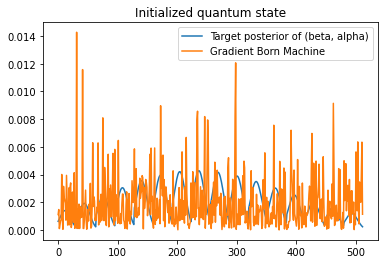

Text(0.5, 1.0, '2D view of target posterior distribution')

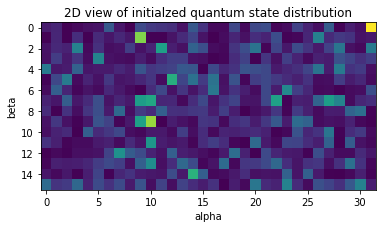

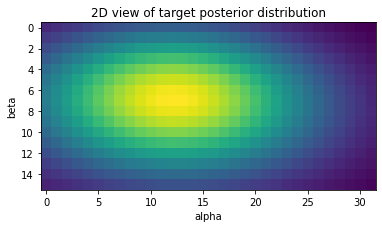

In [79]:
depth = 10
geometry = (3,3)
Q_split = [4,5] # assin number of qubits to beta and alpha resolution
n_qubits = np.prod(geometry)
# follow the order of beta dna alpha
LB = [2600, 600]
UB = [3200, 1200]

# actual a, b
ALPHA = 1000
BETA = 3000 

n_samples = 500
Xs = generate_data(ALPHA, BETA, n_samples) # fixed observations

bm = load_lighthouse_beta_alpha_grid_basis(geometry, depth, lb=LB, ub=UB, n_qubits_at_dim = Q_split, batch_size=None)
bm.batch_size = None
bm.eval_py_on_demand = True

np.random.seed(700)
#theta_list = np.load('true_adversarial_vanilla_batch_4_iter_10000_theta_list.npy')
np.random.seed(123)
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi

pl = bm.pdf_actual(theta_list)
tv = TV(pl, bm.p_data)
print('TV', tv)
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Target posterior of (beta, alpha)', 'Gradient Born Machine'])
plt.title('Initialized quantum state')
plt.show()

plot_p_b_a_2d(pl, Q_split)
plt.title('2D view of initialzed quantum state distribution')
plot_p_b_a_2d(bm.p_data, Q_split)
plt.title('2D view of target posterior distribution')

<h1>Train the quantum circuit

TV_actual 0.8123269322914707


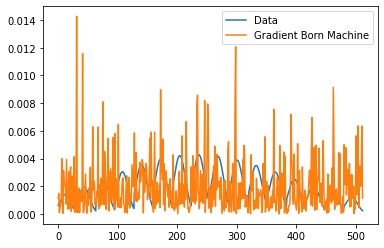

TV 0.7917393986935749
step = 1, mmd loss = 0.005215514633428341
step = 1, mcr loss = 404.71023967877954
TV 0.771360989773479
TV 0.7524606864083048
TV 0.7406031623649557
TV 0.7316758936547517
TV 0.7215977273556542
TV 0.7100859876452121
TV 0.6985145289272522
TV 0.6863892723669875
TV 0.6735940488533064
TV 0.6606598683075062
TV 0.6481237055770895
TV 0.6366531588364839
TV 0.6252635416447416
TV 0.6139080425244894
TV 0.6042578085980888
TV 0.5958500715812911
TV 0.5875432912441517
TV 0.5789742316610968
TV 0.5694561875773487
TV 0.5610074654551426
TV 0.5534350698449741
TV 0.5465896243108135
TV 0.5401616027224401
TV 0.5338595824473201
TV 0.5279198586610592
TV 0.5217224129076614
TV 0.5147662733714901
TV 0.5076187807064699
TV 0.5016580357737639
TV 0.49674661937564024
TV 0.49191295149614234
TV 0.4874068341291283
TV 0.48264039166251566
TV 0.47812342465407653
TV 0.4736263112217213
TV 0.46893267920434706
TV 0.4639779758260445
TV 0.4593023671992028
TV 0.4546990760832986
TV 0.4501268828141489
TV 0.4461780

<ipython-input-70-e8c46bfe61f5>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2)


TV 0.26638839466237535
TV 0.2662100611265425
TV 0.2660229035897553
TV 0.26583061156666243
TV 0.26562946822088823
TV 0.26541837664033424
TV 0.26519722448138733
TV 0.2649672789753278
TV 0.26473466796633693
TV 0.2644918254636651
TV 0.2642436048601841
TV 0.26399214947065264
TV 0.26374195800369926
TV 0.2634860717147433
TV 0.2632545262094509
TV 0.26302840625272006
TV 0.26279130712928567
TV 0.2625521469732174
TV 0.2623051899529756
TV 0.2620467369636051
TV 0.26179524227915446
TV 0.26154619008610297
TV 0.261292337581977
TV 0.26103289906456384
TV 0.2607660429172102
TV 0.2604905496986989
TV 0.26020315216484924
TV 0.2599112636995899
TV 0.25962610509997364
TV 0.2593512478452731
TV 0.2590825761346067
TV 0.25881806954182274
TV 0.2585468844292571
TV 0.2582647469829452
TV 0.2579866399798729
TV 0.2577037577913587
TV 0.2574134493655018
TV 0.2571109753696829
TV 0.25680066862880707
TV 0.2564780460273397
TV 0.25617347325423523
TV 0.2558815390219266
TV 0.25559519529417446
TV 0.2552945476191654
TV 0.254986641

<ipython-input-70-e8c46bfe61f5>:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('ligihthouse_2d_figures/'+str(step[0])+'_plot.png')


TV 0.2493086468083311
TV 0.24888409142480783
TV 0.24845994935707919
TV 0.24803565102879968
TV 0.24761130087513927
TV 0.24718203879458106
TV 0.24676812966093423
TV 0.24638929215367106
TV 0.24603226093307212
TV 0.245665561947643
TV 0.2452849153588002
TV 0.2448905089825492
TV 0.24448264225202843
TV 0.24408451036220719
TV 0.24369919222608885
TV 0.24331530919722327
TV 0.24291939520552747
TV 0.24251609681055472
TV 0.2421169475044017
TV 0.24173375004826442
TV 0.24137589680184446
TV 0.24103483899528372
TV 0.24069320882411607
TV 0.24035092056038984
TV 0.2400077590281569
TV 0.2396577970469106
TV 0.2393136383748562
TV 0.2389607055263904
TV 0.23859819944274224
TV 0.23823173511998635
TV 0.23788328244145124
TV 0.23758956468479864
step = 301, mmd loss = 0.00014381534010330917
step = 301, mcr loss = 102.55069092605129
TV 0.23730366224033825
TV 0.237040645727604
TV 0.23679134408172972
TV 0.2365621676219502
TV 0.23633638642850563
TV 0.2361022643393713
TV 0.23586621453412351
TV 0.23563187026032162
TV 0.2

TV 0.20459968437246467
TV 0.20456882906010843
TV 0.20453720162697736
TV 0.20450542378429803
TV 0.2044737413045234
TV 0.20444175155667488
TV 0.204408983836489
TV 0.20437543288045512
TV 0.20434109338016443
TV 0.204306202286836
TV 0.20427709038439273
TV 0.20424750222207455
TV 0.20421713914837455
TV 0.20418599565561774
TV 0.20415406617180576
TV 0.20412134505725787
TV 0.2040878266011425
TV 0.20405350501793806
TV 0.2040183744438206
TV 0.2039824289329577
TV 0.20394566245372475
TV 0.203908068884888
TV 0.20386964201168767
TV 0.20383037552188793
TV 0.20379026300177588
TV 0.20374931336491325
TV 0.20370948534457833
TV 0.20366881552775482
TV 0.20362820952525107
TV 0.20358790052700507
TV 0.20354960508061842
TV 0.2035104224535469
TV 0.20347034503920658
TV 0.20342950948999966
TV 0.20339081007990145
TV 0.20335119974892554
TV 0.20331067016309196
TV 0.20326921281831184
TV 0.20322681903611908
TV 0.20318347995951452
TV 0.20313918654890795
TV 0.20309392957817182
TV 0.20304769963084174
TV 0.20300048709647608

TV 0.18690622046670918
TV 0.18688308226996328
TV 0.18685949079300723
TV 0.18683544386597578
TV 0.1868109392435574
TV 0.186788241162252
TV 0.18676606337154789
TV 0.18674338934651635
TV 0.1867202169173504
TV 0.1866965438517714
TV 0.18667236785812957
TV 0.18664768658853725
TV 0.18662392023865446
TV 0.18660005492356374
TV 0.18657564967698936
TV 0.18655070191472667
TV 0.18652520901092903
TV 0.1864991683013661
TV 0.1864725770867228
TV 0.186445432635873
TV 0.18641773218918045
TV 0.18638947296180192
TV 0.18636065214695402
TV 0.18633126691917531
TV 0.18630281737310278
TV 0.18627392610463703
TV 0.18624447071386277
TV 0.1862144484233934
TV 0.18618385645115637
TV 0.18615269201343748
TV 0.1861209523278436
TV 0.18608863461620972
TV 0.186055736107395
TV 0.1860222540400273
TV 0.185988185665136


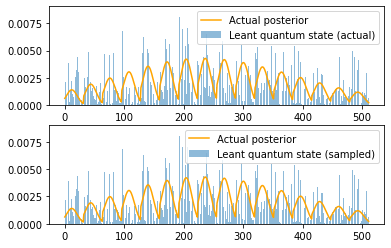

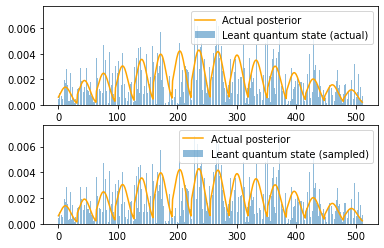

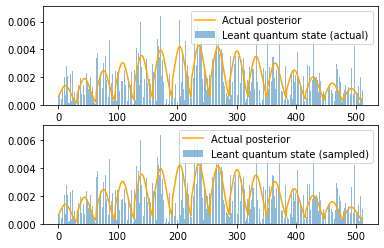

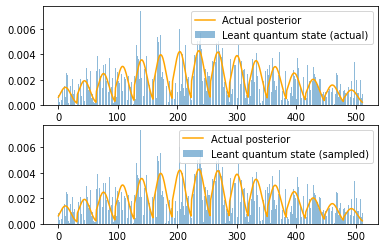

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


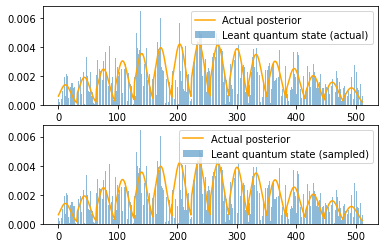

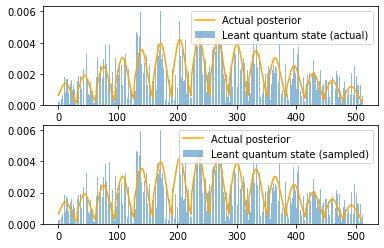

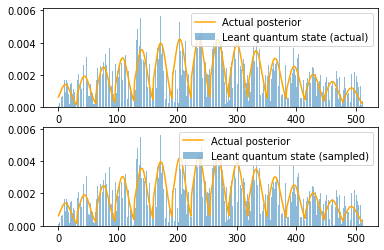

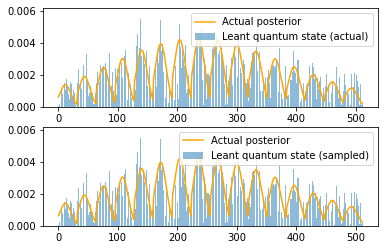

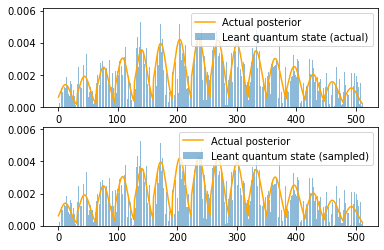

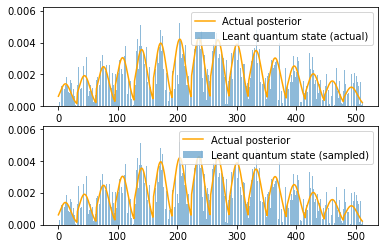

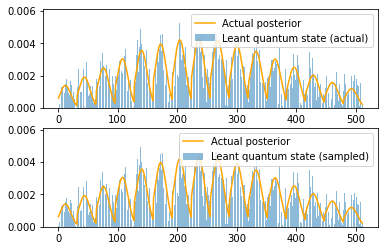

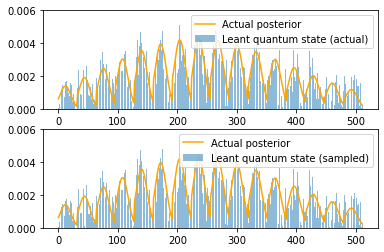

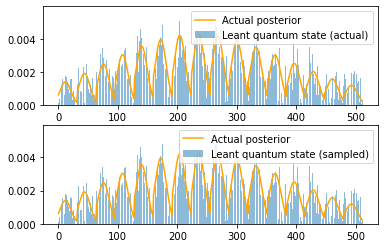

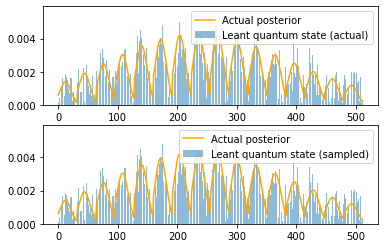

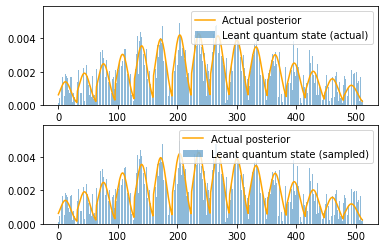

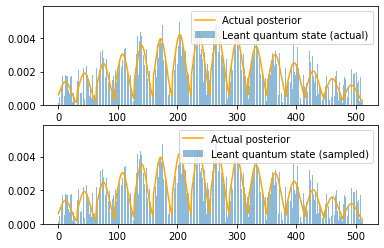

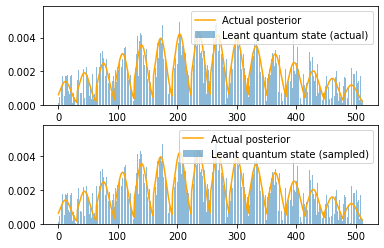

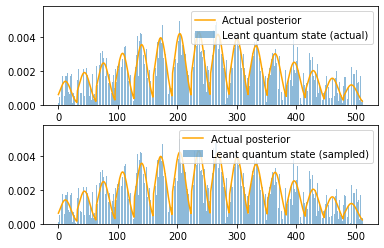

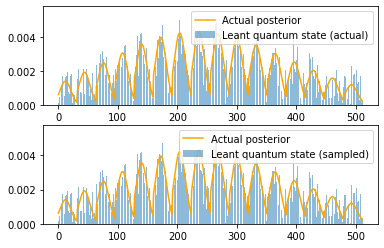

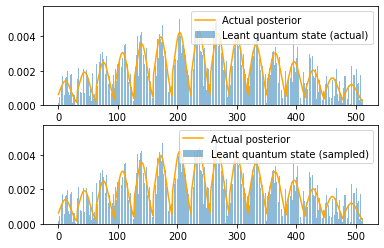

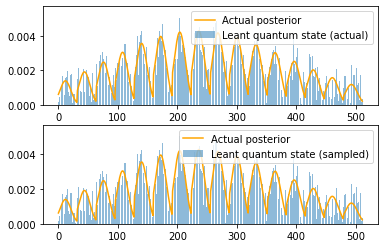

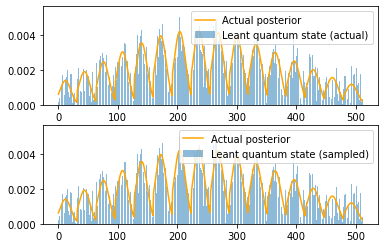

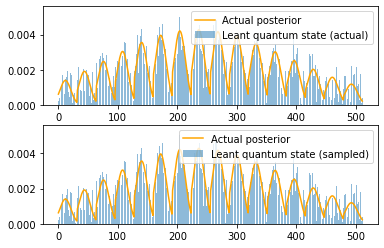

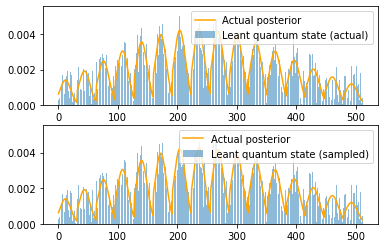

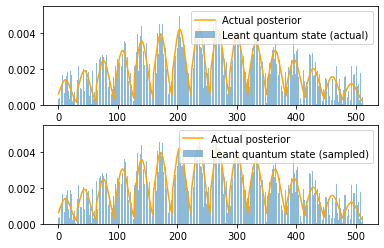

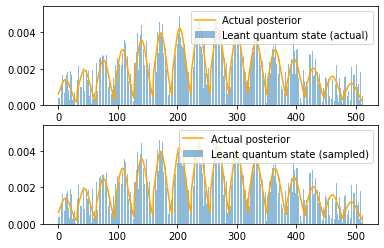

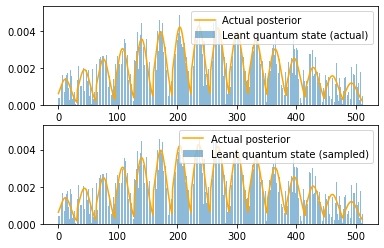

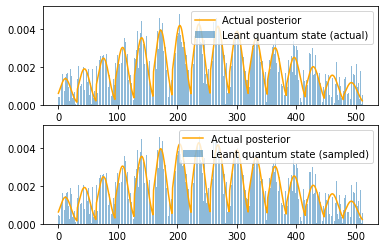

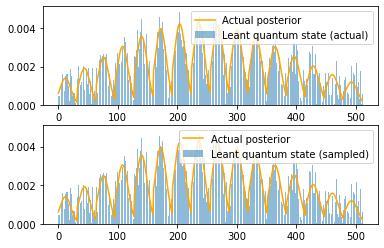

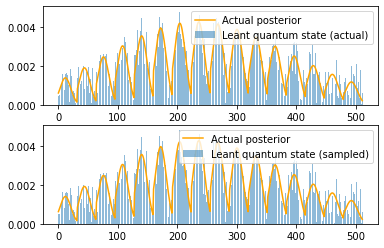

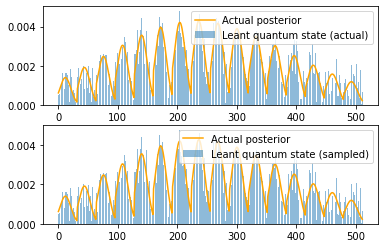

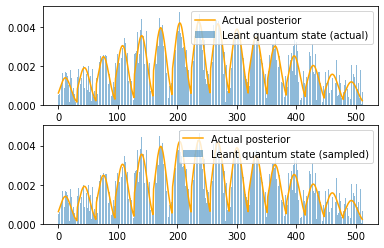

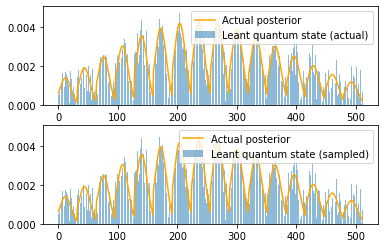

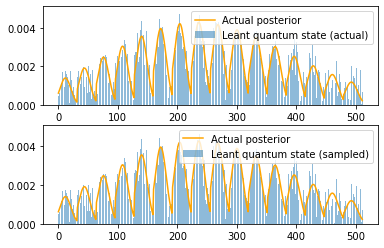

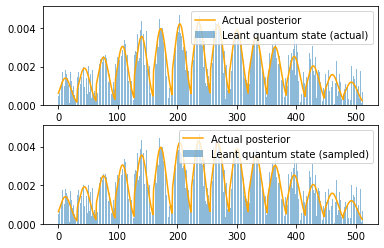

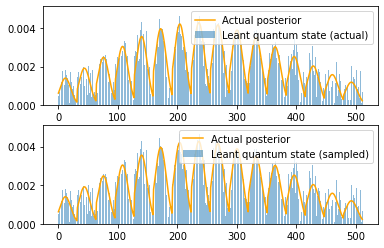

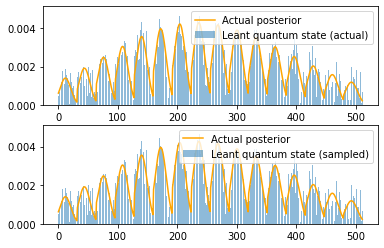

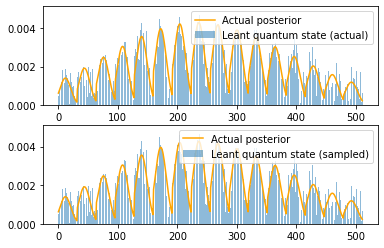

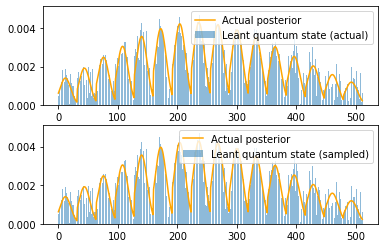

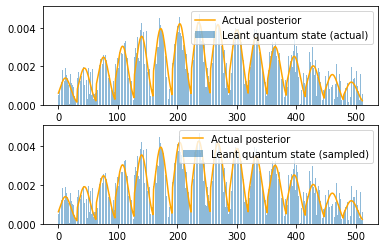

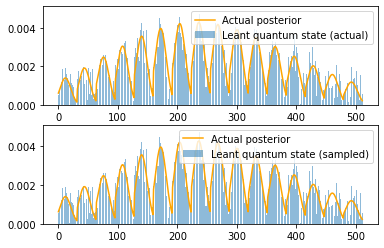

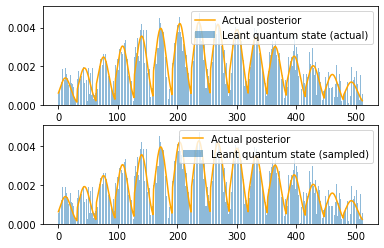

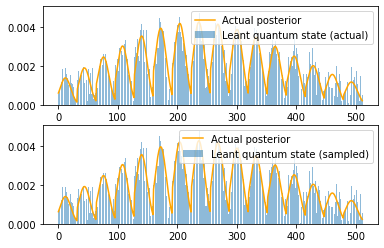

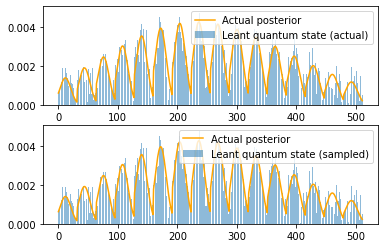

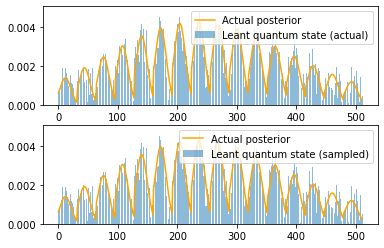

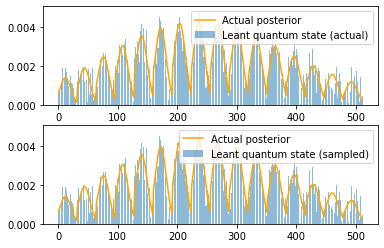

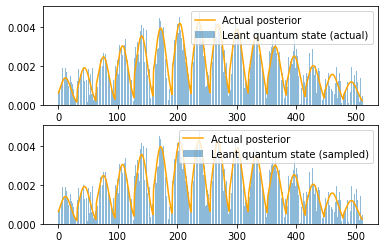

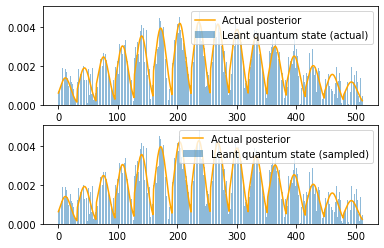

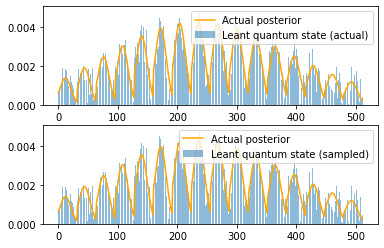

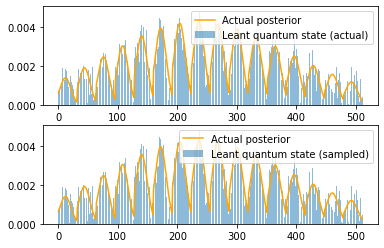

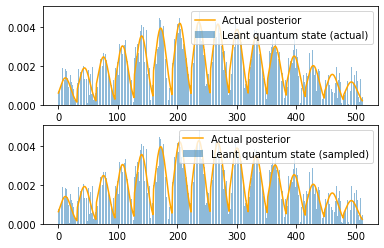

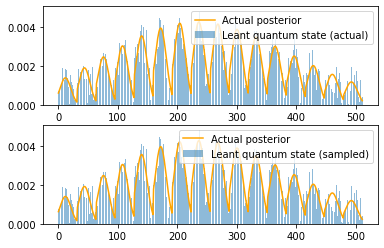

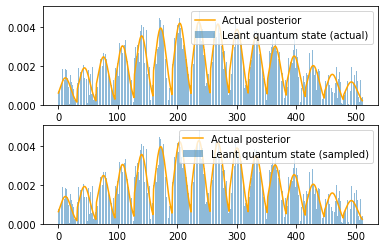

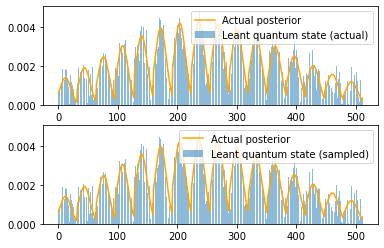

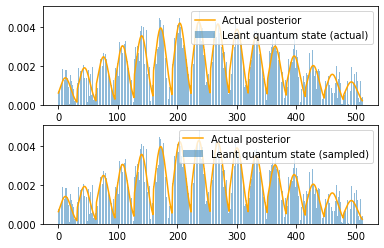

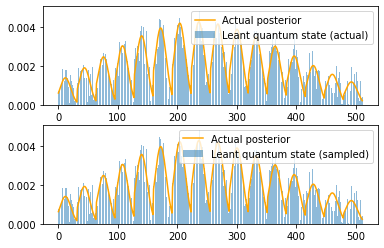

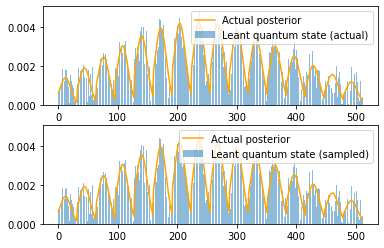

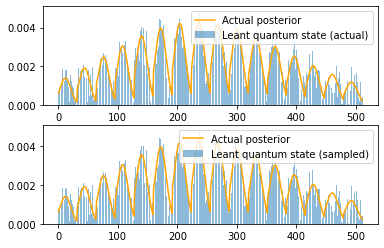

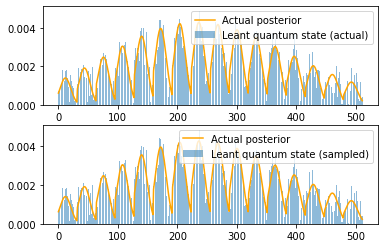

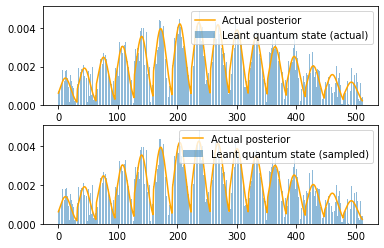

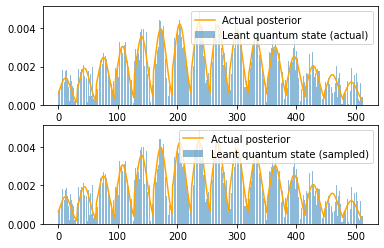

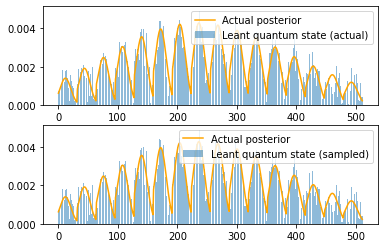

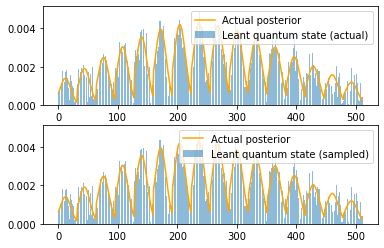

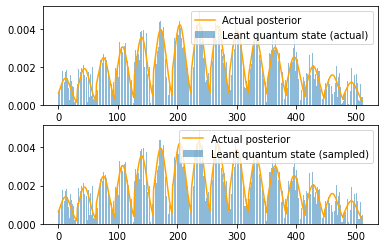

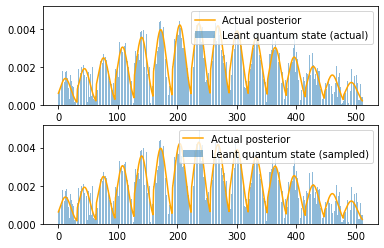

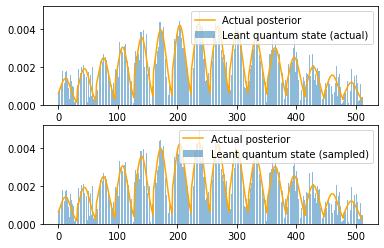

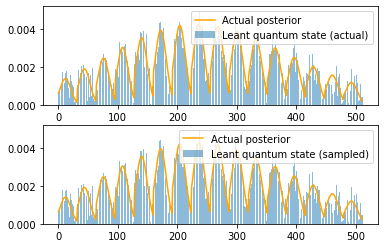

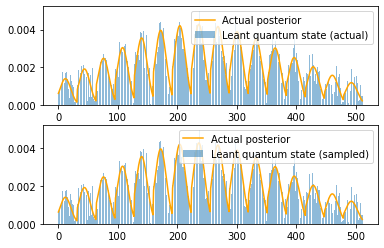

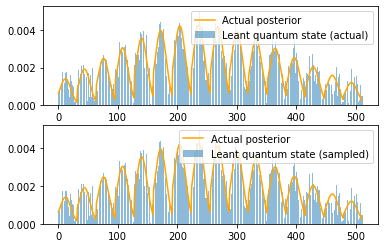

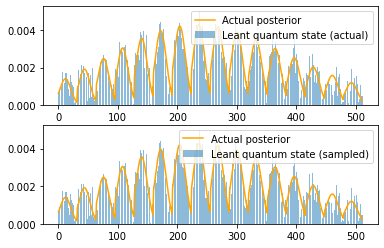

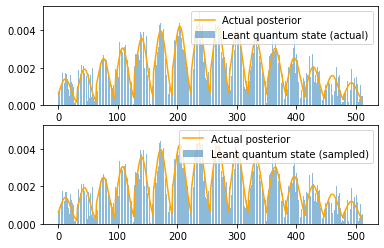

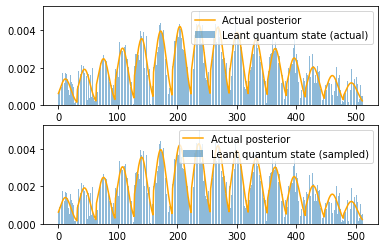

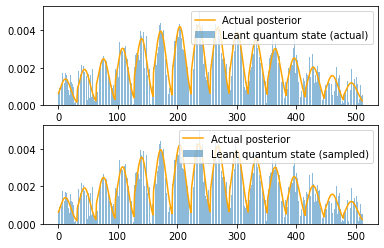

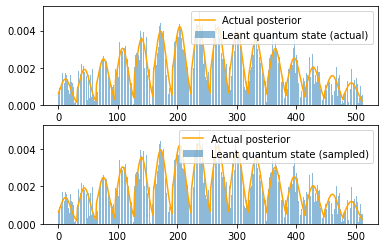

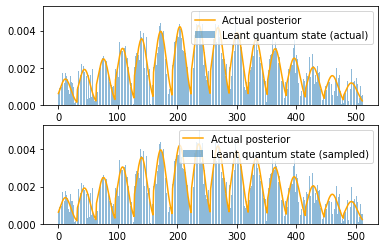

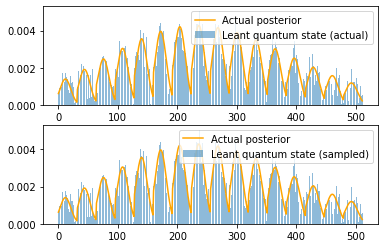

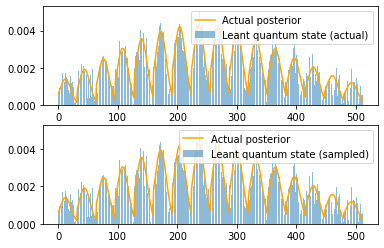

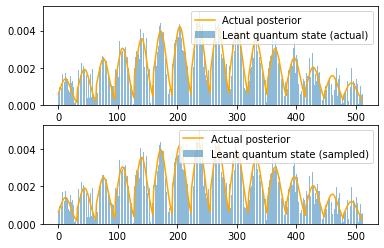

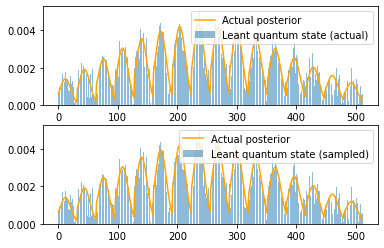

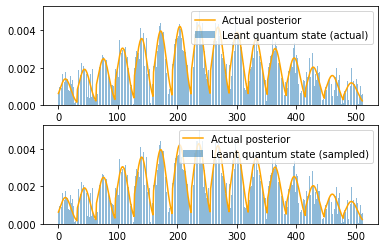

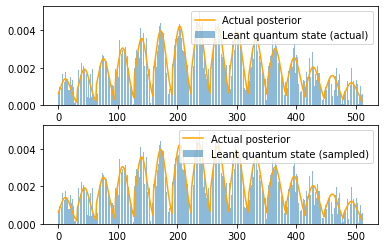

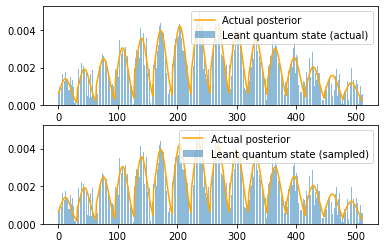

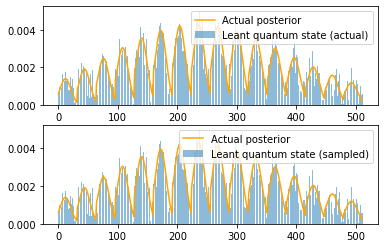

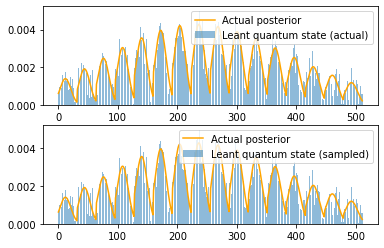

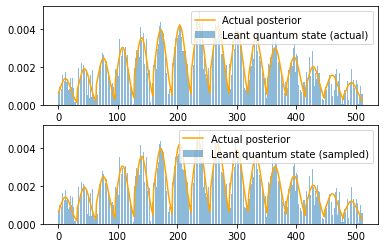

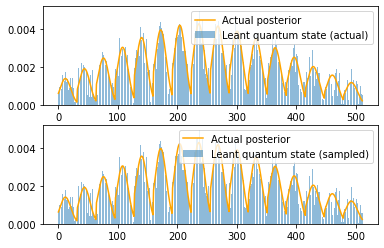

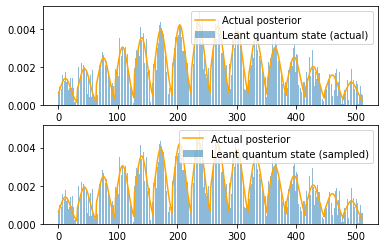

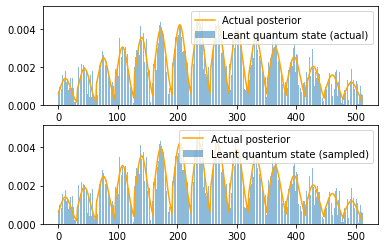

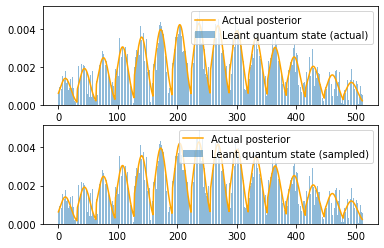

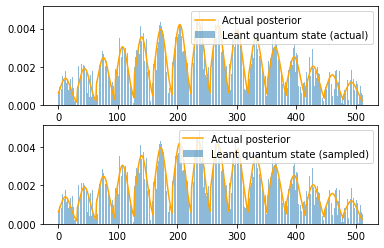

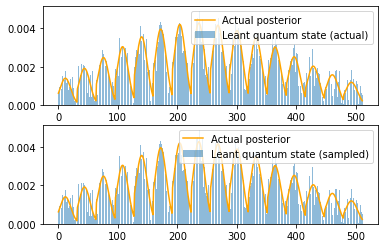

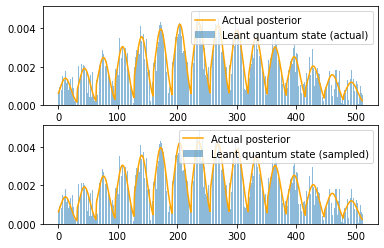

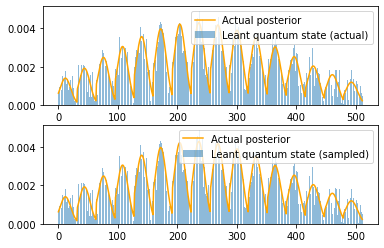

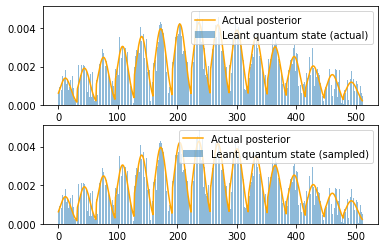

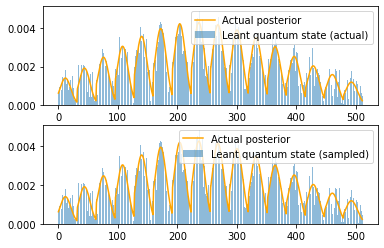

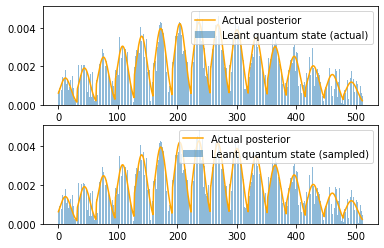

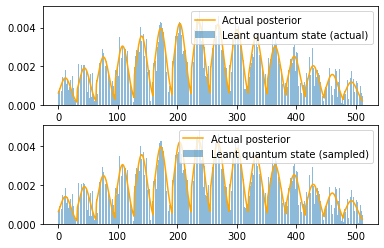

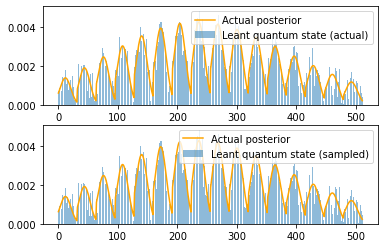

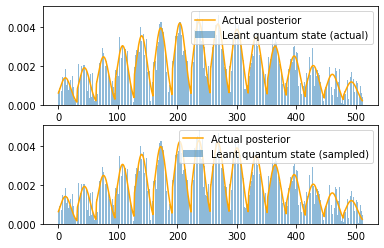

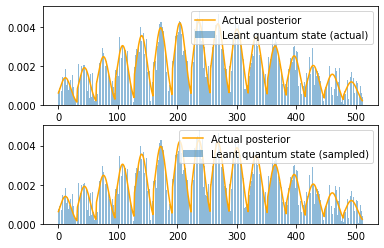

In [80]:
pl = bm.pdf_actual(theta_list)
tv = TV(pl, bm.p_data)
print('TV_actual', tv)
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine'])
plt.show()

loss, theta_list, mcr_values, mmd_values, TVs, best_iter, best_theta_list, born_p_list = train(bm, theta_list, 'Adam', max_iter=1000, popsize=10, step_rate = 0.01, 
                         gradient='MMD') # popsize is obsolete


Plot learning results

TV 1.4849953460541068
TV_actual 0.5286249048790376


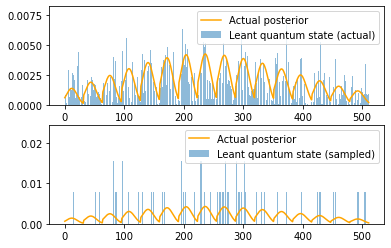

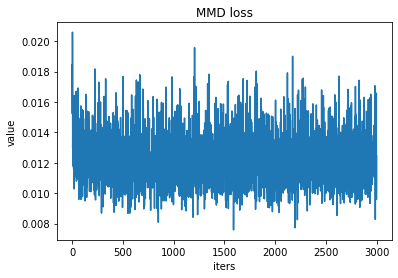

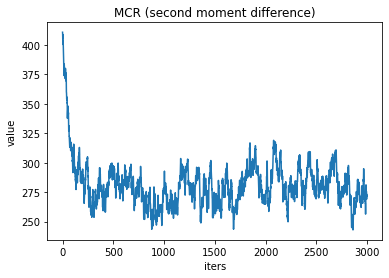

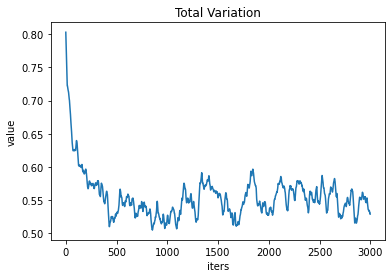

In [78]:
pl_sample = bm.pdf(theta_list)
pl_actual = bm.pdf_actual(theta_list)

tv_sample = TV(pl_sample, bm.p_data)
tv_actual = TV(pl_actual, bm.p_data)


print('TV', tv)
print('TV_actual', tv_actual)

# display

fig, axs = plt.subplots(2)
axs[0].plot(bm.p_data, color='orange')
axs[0].bar(range(len(pl_actual)), pl_actual, alpha=0.5)
axs[0].legend(['Actual posterior', 'Leant quantum state (actual)'])

axs[1].plot(bm.p_data, color='orange')
axs[1].bar(range(len(pl_sample)), pl_sample, alpha=0.5)
axs[1].legend(['Actual posterior', 'Leant quantum state (sampled)'])
plt.show()

plt.plot(mmd_values)
plt.title('MMD loss')
plt.xlabel('iters')
plt.ylabel('value')
plt.show()

plt.plot(mcr_values)
plt.title('MCR (second moment difference)')
plt.xlabel('iters')
plt.ylabel('value')
plt.show()

plt.plot(TVs)
plt.title('Total Variation')
plt.xlabel('iters')
plt.ylabel('value')
plt.show()

Now, sample from the quantum state

(array([ 228.,  363.,  395.,  214.,  238.,  163.,  290.,  380.,  445.,
         465.,  268.,  120.,  212.,  475.,  611.,  479.,  455.,  231.,
         258.,  498.,  753.,  763.,  557.,  297.,  135.,  602.,  749.,
         963.,  766.,  423.,  196.,  422.,  812.,  993.,  902.,  625.,
         335.,  417.,  824.,  968., 1027.,  732.,  458.,  268.,  679.,
        1237., 1006.,  788.,  454.,  270.,  590.,  910., 1058.,  939.,
         709.,  266.,  369.,  732., 1001.,  931.,  660.,  309.,  244.,
         777.,  840.,  801.,  573.,  412.,  202.,  548.,  706.,  749.,
         797.,  381.,  180.,  387.,  506.,  634.,  604.,  272.,  181.,
         317.,  422.,  491.,  394.,  344.,  230.,  242.,  236.,  345.,
         456.,  357.,  242.,   97.,  187.,  317.,  300.,  240.,  146.,
         160.]),
 array([  0.  ,   5.11,  10.22,  15.33,  20.44,  25.55,  30.66,  35.77,
         40.88,  45.99,  51.1 ,  56.21,  61.32,  66.43,  71.54,  76.65,
         81.76,  86.87,  91.98,  97.09, 102.2 , 107.31, 11

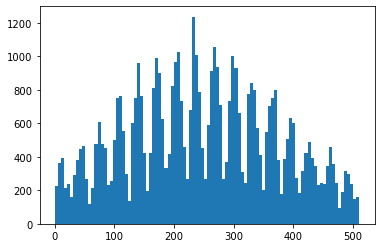

In [63]:
pl_best = bm.pdf_actual(best_theta_list)
samples = sample_from_prob(np.arange(len(pl_best)), pl_best, 50000)
plt.hist(samples, bins=100)

Post process the learnt probability at each iteration

In [ ]:
for i in range(len(born_p_list)):
    fig = plot_p_b_a_2d(born_p_list[i], Q_split)
    fig.savefig('lighthouse_2d_color_map/'+str(i)+'_plot.png')

<h1>Lighthouse 1-dimensional: sampling from posterior (with uniform prior)
<a id='lighthouse_1D'></a>

Set up the hyperparameters

In [ ]:
depth = 4
geometry = (2,3)
Q_split = [0,6] #[beta, alpha] order
n_qubits = np.prod(geometry)

# actual a, b to generate the observations
ALPHA = 1000
BETA = 3000 

# follow the order of beta and alpha
LB = [3000, 600]
UB = [3000, 1200]



n_samples = 500
Xs = generate_data(ALPHA, BETA, n_samples) # fixed observations

bm = load_lighthouse_beta_alpha_grid_basis(geometry, depth, lb=LB, ub=UB, n_qubits_at_dim = Q_split, batch_size=None)
bm.batch_size = 520
np.random.seed(700)
#theta_list = np.load('true_adversarial_vanilla_batch_4_iter_10000_theta_list.npy')
np.random.seed(123)
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi

pl = bm.pdf_actual(theta_list)
tv = TV(pl, bm.p_data)
print('TV', tv)
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine'])
plt.title('Initialized quantum state distribution')
plt.show()

plot_p_b_a_2d(pl, Q_split)
plt.title('1D view of initialzed quantum state distribution')
plot_p_b_a_2d(bm.p_data, Q_split)
plt.title('1D view of target posterior distribution')

<h1>Train the quantum circuit

In [ ]:
pl = bm.pdf_actual(theta_list)
tv = TV(pl, bm.p_data)
print('TV_actual', tv)
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine'])
plt.show()

loss, theta_list, mcr_values, mmd_values, TVs, best_iter, best_theta_list, born_p_list = train(bm, theta_list, 'Adam', max_iter=100, popsize=10, step_rate = 0.01, 
                         gradient='MMD') # popsize is obsolete


Plot learning results

In [ ]:
pl = bm.pdf(theta_list)
pl_actual = bm.pdf_actual(theta_list)

tv = TV(pl, bm.p_data)
tv_actual = TV(pl_actual, bm.p_data)


print('TV', tv)
print('TV_actual', tv_actual)

# display
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine (sampled)'])
plt.show()

plt.plot(bm.p_data)
plt.plot(pl_actual)
plt.legend(['Data', 'Gradient Born Machine (actual)'])
plt.show()

plt.plot(mmd_values)
plt.title('MMD loss')
plt.xlabel('iters')
plt.ylabel('value')
plt.show()

plt.plot(mcr_values)
plt.title('MCR loss')
plt.xlabel('iters')
plt.ylabel('value')
plt.show()

plt.plot(TVs)
plt.title('Total Variation')
plt.xlabel('iters')
plt.ylabel('value')
plt.show()

Post process the learnt probability at each iteration

In [ ]:
for i in range(len(born_p_list)):
    fig = plot_p_b_a_2d(born_p_list[i], Q_split)
    fig.savefig('lighthouse_2d_color_map/'+str(i)+'_plot.png')